# Analysis

## Model 

### The distributions of std of LLaVa rating for each image across different rating aspects.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def plot_stddev_boxplot(ratings_file, output_image):
    """
    Draw the boxplot for the standard deviation of each image across different rating aspects.
    """
    df = pd.read_excel(ratings_file)
    std_df = df.groupby("image").std()
    
    # Melt the DataFrame for visualization
    std_melted = std_df.reset_index().melt(id_vars=["image"], var_name="Rating Type", value_name="Standard Deviation")
    
    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'STIXGeneral'
    sns.boxplot(x="Rating Type", y="Standard Deviation", data=std_melted)
    # plt.title("Standard Deviation of LLaVa Ratings per Image", fontsize=15, fontweight="bold")
    plt.xticks(rotation=0, fontweight="bold", fontsize=16)
    plt.xlabel("")
    plt.ylabel("Standard Deviation", fontsize=16, fontweight="bold")
    plt.savefig(output_image)
    plt.show()
    
    print(f"Box plot saved as {output_image}")

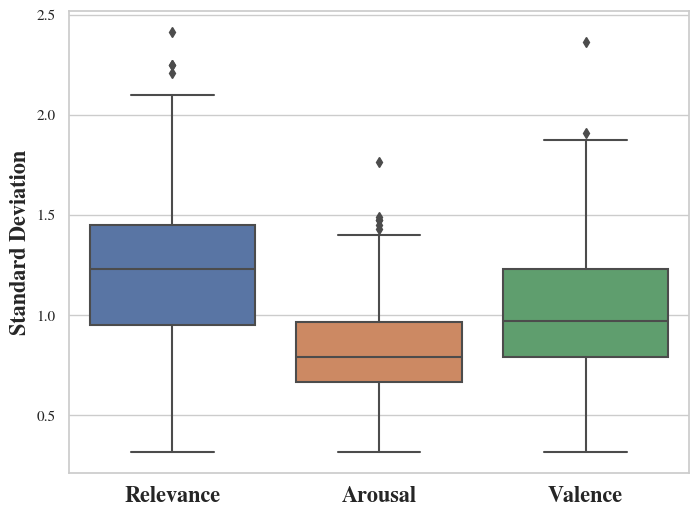

Box plot saved as Figure\stddev_boxplot.png


In [2]:
plot_stddev_boxplot(
    r"C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Output_LLaVa_Ratings_all_320.xlsx", 
    "Figure\stddev_boxplot.png"
    )

### Consistency and Correlation of LLaVa ratings

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def analyze_consistency(ratings_file):
    """"
    Analyze the consitency and correlation between different model ouputs:
    ICC score, Heatmap, ICC score distribution.
    """
    df = pd.read_excel(ratings_file)
    
    # Compute intra-class correlation (ICC)
    icc_values = df.groupby("image").apply(lambda x: stats.variation(x.drop(columns=["image"], errors='ignore'), axis=1).mean())
    icc_df = icc_values.reset_index()
    icc_df.columns = ["image", "ICC"]

    icc_summary = icc_df["ICC"].describe()
    print("ICC Statistical Summary:\n", icc_summary)
    
    # Correlation heatmap
    correlation_matrix = df.drop(columns=["image"], errors='ignore').corr()
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'STIXGeneral'
    sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f", annot_kws={"size":12})
    plt.xticks(fontsize=16, fontweight="bold")
    plt.yticks(fontsize=16, fontweight="bold")
    plt.savefig("Figure/correlation_matrix.png")
    plt.show()
    
    # Plot consistency analysis
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'STIXGeneral'
    sns.histplot(icc_df["ICC"], bins=30, kde=True)
    # plt.title("Intra-Class Correlation (ICC) of LLaVa Ratings", fontsize=15, fontweight="bold")
    plt.xlabel("")
    plt.ylabel("Frequency", fontsize=16, fontweight="bold")
    plt.savefig( "Figure/consistency_analysis.png")
    plt.show()
    
    print("Consistency analysis plot saved as  consistency_analysis.png")
    print("Correlation matrix plot saved as correlation_matrix.png")


ICC Statistical Summary:
 count    320.000000
mean       0.241610
std        0.089812
min        0.078761
25%        0.181246
50%        0.219420
75%        0.274945
max        0.806711
Name: ICC, dtype: float64


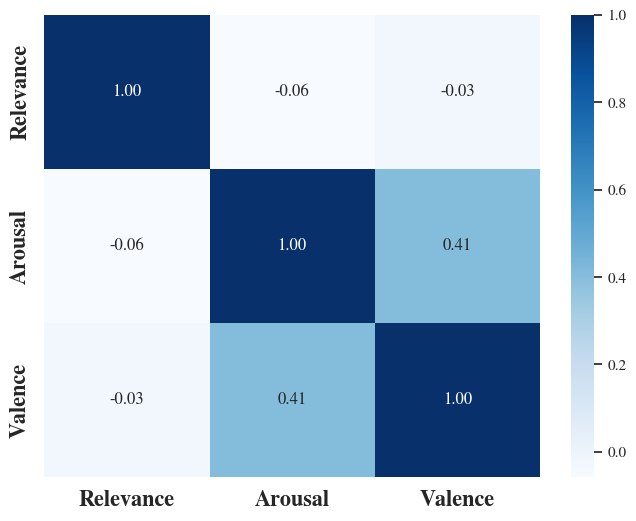

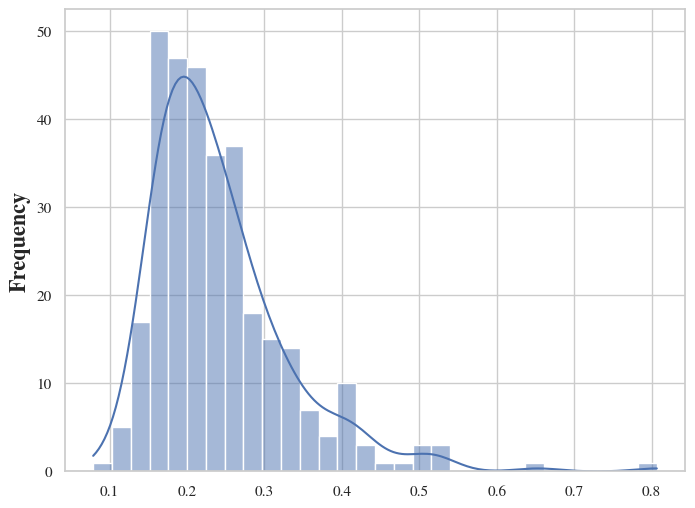

Consistency analysis plot saved as  consistency_analysis.png
Correlation matrix plot saved as correlation_matrix.png


In [5]:
analyze_consistency(
    r"C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Output_LLaVa_Ratings_all_320.xlsx", 
    )

Results above show the LLaVa ratings of each image may not achieve a high consistency, revealing non-ideal model robustness.

This may be attributed to **the ability of model itself** (instead of 34b model, I use 13b LLaVa because of the shortage of computation resources), **the lack of fine-tuning**, etc. 

## Model versus Human

### Directional Test

This part, I compare avg_llava_rating and avg_human_rating(raw data)

I use Wilcoxon Signed-Rank Directional Test to validate the direction of the difference among ratings.

In [10]:
def perform_directional_test(ratings_file, column_pairs):
    """
    Performs a directional Wilcoxon signed-rank test (one-sided) for paired ratings 
    """
    df = pd.read_excel(ratings_file)

    results = []
    for col_A, col_B in column_pairs:
        x = df.iloc[:, col_A]
        y = df.iloc[:, col_B]

        col_A_name = df.columns[col_A]
        col_B_name = df.columns[col_B]

        # Perform Wilcoxon signed-rank test (one-sided for greater and less)
        stat_greater, p_value_greater = stats.wilcoxon(x, y, alternative='greater')  # Tests if col_A > col_B
        stat_less, p_value_less = stats.wilcoxon(x, y, alternative='less')  # Tests if col_A < col_B

        # Iinterpretation
        if p_value_greater < 0.05:
            interpretation = r"\textbf{$\uparrow$ Higher (Significant)}"
        elif p_value_less < 0.05:
            interpretation = r"\textbf{$\downarrow$ Lower (Significant)}"
        else:
            interpretation = r"\textbf{$\rightarrow$ No Significant Difference}"

        results.append({
            "Comparison": f"{col_A_name} vs. {col_B_name}",
            "Wilcoxon Statistic": round(stat_greater, 2),
            "p-value (Higher)": round(p_value_greater, 2),
            "p-value (Lower)": round(p_value_less, 2),
            "Interpretation": interpretation
        })

    results_df = pd.DataFrame(results)
    print(results_df)


In [11]:
column_pairs = [(1, 4), (2, 5), (3, 6)]
perform_directional_test(
    r"C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\merged_avg_ratings_llava_human_all_320.xlsx", 
    column_pairs
    )

                            Comparison  Wilcoxon Statistic  p-value (Higher)  \
0  Avg_Relevance vs. Raw_Avg_Relevance              8114.0               1.0   
1      Avg_Arousal vs. Raw_Avg_Arousal             23086.5               0.9   
2      Avg_Valence vs. Raw_Avg_Valence             34042.0               0.0   

   p-value (Lower)                                    Interpretation  
0              0.0         \textbf{$\downarrow$ Lower (Significant)}  
1              0.1  \textbf{$\rightarrow$ No Significant Difference}  
2              1.0          \textbf{$\uparrow$ Higher (Significant)}  


### Equivalence Test

It turns out that there is no significant difference between LLaVa rating and Human rating corresponding to Arousal.

Now I use TOST to test the equivalence of all the ratings between LLaVa and Human.

In [12]:
   
import pandas as pd
import scipy.stats as stats

def perform_tost_equivalence_test(ratings_file, column_pairs, equivalence_margin=0.1):
    """
    Perform tost equivalence test of all ratings.
    Set 0.1 as delta, i.e. the equivalence marigin.
    """
    df = pd.read_excel(ratings_file)
    
    results = []
    for col1_idx, col2_idx in column_pairs:
        col1_name = df.columns[col1_idx]
        col2_name = df.columns[col2_idx]
        sample1 = df.iloc[:, col1_idx]
        sample2 = df.iloc[:, col2_idx]
        
        # Perform TOST equivalence test
        mean_diff = sample1.mean() - sample2.mean()
        lower_bound = -equivalence_margin
        upper_bound = equivalence_margin
        
        # Left and Right one-tailed t-test
        t_left, p_left = stats.ttest_ind(sample1, sample2, alternative='greater')
        t_right, p_right = stats.ttest_ind(sample1, sample2, alternative='less')
        
        # Set equivalence at significance level ==0.05
        equivalent = (p_left > 0.05) and (p_right > 0.05)
        
        print(f"TOST Equivalence Test for {col1_name} vs {col2_name}")
        print(f"  Mean Difference: {mean_diff}")
        print(f"  Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"  p-value (left): {p_left}")
        print(f"  p-value (right): {p_right}")
        print(f"  Equivalent: {equivalent}")
        print("-" * 40)
        
        results.append({
            "Comparison": f"{col1_name} vs {col2_name}",
            "Mean Difference": mean_diff,
            "Lower Bound": lower_bound,
            "Upper Bound": upper_bound,
            "p-value (left)": p_left,
            "p-value (right)": p_right,
            "Equivalent": equivalent
        })
    
    return results

In [13]:
column_pairs = [(1, 4), (2, 5), (3, 6)]
perform_tost_equivalence_test(
    r"C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\merged_avg_ratings_llava_human_all_320.xlsx", 
    column_pairs
    )

TOST Equivalence Test for Avg_Relevance vs Raw_Avg_Relevance
  Mean Difference: -0.9239375000000045
  Lower Bound: -0.1, Upper Bound: 0.1
  p-value (left): 0.9999999999999991
  p-value (right): 8.813704203671858e-16
  Equivalent: False
----------------------------------------
TOST Equivalence Test for Avg_Arousal vs Raw_Avg_Arousal
  Mean Difference: -0.06653124999999971
  Lower Bound: -0.1, Upper Bound: 0.1
  p-value (left): 0.8793544123657432
  p-value (right): 0.1206455876342568
  Equivalent: True
----------------------------------------
TOST Equivalence Test for Avg_Valence vs Raw_Avg_Valence
  Mean Difference: 0.2824687500000005
  Lower Bound: -0.1, Upper Bound: 0.1
  p-value (left): 0.0017587695280021336
  p-value (right): 0.9982412304719979
  Equivalent: False
----------------------------------------


[{'Comparison': 'Avg_Relevance vs Raw_Avg_Relevance',
  'Mean Difference': -0.9239375000000045,
  'Lower Bound': -0.1,
  'Upper Bound': 0.1,
  'p-value (left)': 0.9999999999999991,
  'p-value (right)': 8.813704203671858e-16,
  'Equivalent': False},
 {'Comparison': 'Avg_Arousal vs Raw_Avg_Arousal',
  'Mean Difference': -0.06653124999999971,
  'Lower Bound': -0.1,
  'Upper Bound': 0.1,
  'p-value (left)': 0.8793544123657432,
  'p-value (right)': 0.1206455876342568,
  'Equivalent': True},
 {'Comparison': 'Avg_Valence vs Raw_Avg_Valence',
  'Mean Difference': 0.2824687500000005,
  'Lower Bound': -0.1,
  'Upper Bound': 0.1,
  'p-value (left)': 0.0017587695280021336,
  'p-value (right)': 0.9982412304719979,
  'Equivalent': False}]

The TOST result suggests that there is statistically equivalence between LLaVa ratings and Human Ratings when it comes to the Arousal of the image.

### Addtional Quantitative Analysis

Now, to quantitatively analyze the difference between LLaVa and Human ratings, I calculate the errors(MSE) and the variances (Avg_LLaVa Rating\-Avg_Human Rating).

In [15]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def compute_mse(ratings_file, column_pairs):
    """
    Calcute the MSE between LLaVa and Human Ratings across different aspects.
    """
    df = pd.read_excel(ratings_file)
    
    results = []
    for col1_idx, col2_idx in column_pairs:
        col1_name = df.columns[col1_idx]
        col2_name = df.columns[col2_idx]
        sample1 = df.iloc[:, col1_idx]
        sample2 = df.iloc[:, col2_idx]
        
        # Compute MSE
        mse_value = mean_squared_error(sample1, sample2)
        
        print(f"MSE for {col1_name} vs {col2_name}: {mse_value:.4f}")
        
        results.append({
            "Comparison": f"{col1_name} vs {col2_name}",
            "MSE": mse_value
        })
    
    return results


In [16]:
column_pairs = [(1, 4), (2, 5), (3, 6)]
compute_mse(
    r"C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\merged_avg_ratings_llava_human_all_320.xlsx",
    column_pairs)

MSE for Avg_Relevance vs Raw_Avg_Relevance: 2.4947
MSE for Avg_Arousal vs Raw_Avg_Arousal: 1.2677
MSE for Avg_Valence vs Raw_Avg_Valence: 0.9960


[{'Comparison': 'Avg_Relevance vs Raw_Avg_Relevance', 'MSE': 2.494694375},
 {'Comparison': 'Avg_Arousal vs Raw_Avg_Arousal', 'MSE': 1.2677390625},
 {'Comparison': 'Avg_Valence vs Raw_Avg_Valence', 'MSE': 0.9959659375}]

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_column_differences(ratings_file, column_pairs):
    """
    Computes differences between specified rating pairs, 
    and visualizes the results using a box plot.
    """
    df = pd.read_excel(ratings_file)

    # Compute column differences
    diff_data = {}
    for i, (col_A, col_B) in enumerate(column_pairs):
        diff_name = f"Diff_Col{col_A+1}_Col{col_B+1}" 
        diff_data[diff_name] = df.iloc[:, col_A] - df.iloc[:, col_B]
    
    diff_df = pd.DataFrame(diff_data)

    # Create box plot
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'STIXGeneral'
    sns.boxplot(data=diff_df)
    ax = sns.boxplot(data=diff_df)
    ax.set_xticklabels(["Relevance","Arousal","Valence"],fontweight="bold", fontsize=16)
    plt.xlabel("")
    plt.ylabel("Variance", fontsize=16, fontweight="bold")
    # plt.title("Boxplot of Variances Between Columns")
    plt.savefig("Figure/Variance_boxplot.png")
    plt.show()

    print("Variance boxplot saved as Figure/Variance_boxplot.png")

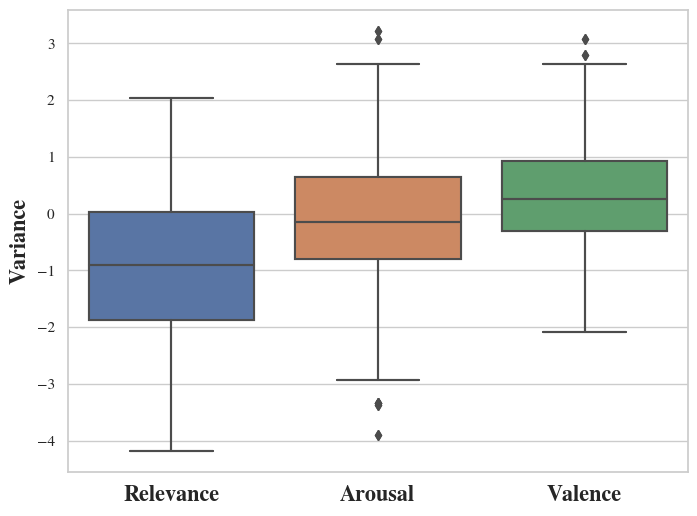

Variance boxplot saved as Figure/Variance_boxplot.png


In [18]:
column_pairs = [(1, 4), (2, 5), (3, 6)]
plot_column_differences(
    r"C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\merged_avg_ratings_llava_human_all_320.xlsx",
    column_pairs)

# Additional Analysis

In [7]:
import pandas as pd

def calculate_means(input_file, output_file):

    df = pd.read_excel(input_file)
    result = pd.DataFrame(columns=['image', 'Avg_Relevance', 'Avg_Arousal', 'Avg_Valence'])
    unique_images = df['image'].unique()

    for image in unique_images:

        image_data = df[df['image'] == image]
        
        for i in range(1, len(image_data) + 1):
            subset = image_data.iloc[:i]
            mean_relevance = subset['Relevance'].mean()
            mean_arousal = subset['Arousal'].mean()
            mean_valence = subset['Valence'].mean()

            temp_result = pd.DataFrame({
                'image': [image],
                'Avg_Relevance': [mean_relevance],
                'Avg_Arousal': [mean_arousal],
                'Avg_Valence': [mean_valence]
            })
            
            result = pd.concat([result, temp_result], ignore_index=True)

    result.to_excel(output_file, index=False)
    print(f"All results are written to '{output_file}'")

In [8]:
input_file = r'C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Output_LLaVa_Ratings_all_320.xlsx'  
output_file = r'C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Output_LLaVa_Mean_Ratings_all_320.xlsx'  
calculate_means(input_file, output_file)

All results are written to 'C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Output_LLaVa_Mean_Ratings_all_320.xlsx'


In [20]:
import os
import pandas as pd

def split_to_multiple_xlsx(input_file, output_dir, output_prefix):
    """
    To split the mean rating file to ten separate files, make further analysis simplier.
    """
    df = pd.read_excel(input_file)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    num_rows = len(df)
    
    for i in range(10):
        subset = df.iloc[i::10]
        
        output_file = os.path.join(output_dir, f'{output_prefix}_group_{i + 1}.xlsx')
        
        subset.to_excel(output_file, index=False)
        
        print(f'Save file: {output_file}')
        
    print("All files ready")


In [21]:
input_file = r'C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Output_LLaVa_Mean_Ratings_all_320.xlsx'
output_dir = r"C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Mean_Folder"
output_prefix = 'Output_LLaVa_Mean_Ratings_all_320'

split_to_multiple_xlsx(input_file, output_dir, output_prefix)

Save file: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Mean_Folder\Output_LLaVa_Mean_Ratings_all_320_group_1.xlsx
Save file: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Mean_Folder\Output_LLaVa_Mean_Ratings_all_320_group_2.xlsx
Save file: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Mean_Folder\Output_LLaVa_Mean_Ratings_all_320_group_3.xlsx
Save file: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Mean_Folder\Output_LLaVa_Mean_Ratings_all_320_group_4.xlsx
Save file: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Mean_Folder\Output_LLaVa_Mean_Ratings_all_320_group_5.xlsx
Save file: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Ev

## More Analysis for Correlation, MAE, MSE

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_mae_mse(df1, df2):
    """Compute MAR and MSE"""
    mae = mean_absolute_error(df1, df2)
    mse = mean_squared_error(df1, df2)
    return mae, mse

def plot_correlation_heatmap(df1, df2, output_file, comparison_columns, group_columns):
    """Plot the Correlation Matrices"""
    corr_matrix = pd.concat([df1, df2], axis=1).corr().iloc[:3, 3:]

    corr_matrix.columns = comparison_columns  # x-axis: human rating
    corr_matrix.index = group_columns  # y-axis: llm rating
    
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'STIXGeneral'
    sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", annot_kws={"size":12})
    plt.xticks(fontsize=13, fontweight="bold")
    plt.yticks(fontsize=13, fontweight="bold")
    plt.savefig(output_file)
    plt.show()

def calculate_mae_mse_for_files_and_plot_heatmaps(input_dir, comparison_file, output_dir):
    """All-in-one function"""
    comparison_df = pd.read_excel(comparison_file)
    comparison_data = comparison_df.iloc[1:, 1:4] 
    
 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    

    comparison_columns = comparison_df.columns[1:4].tolist()

    all_mae_mse_output_file = os.path.join(output_dir, 'all_mae_mse_results.txt') # all-in-one txt file
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.xlsx'):
            input_file = os.path.join(input_dir, filename)
            # print(f"Processing: {input_file}")
            
            group_df = pd.read_excel(input_file)
            group_data = group_df.iloc[1:, 1:4] 
            
            group_columns = group_df.columns[1:4].tolist() 
            
            mae_mse = {}

            for col_idx in range(3): 
                mae, mse = calculate_mae_mse(group_data.iloc[:, col_idx], comparison_data.iloc[:, col_idx])
                mae_mse[group_data.columns[col_idx]] = {'MAE': mae, 'MSE': mse}
            # print(f'{filename} MAE and MSE:')
            for col, metrics in mae_mse.items():
                print(f'{col} - MAE: {metrics["MAE"]}, MSE: {metrics["MSE"]}')
            
            with open(all_mae_mse_output_file, 'a') as f:
                f.write(f'----- {filename} -----\n')
                for col, metrics in mae_mse.items():
                    f.write(f'{col} - MAE: {metrics["MAE"]}, MSE: {metrics["MSE"]}\n')
                f.write("\n")
            print(f'MAE and MSE results saved to: {all_mae_mse_output_file}')


            heatmap_output_file = os.path.join(output_dir, f'correlation_matrix_{filename}.png')
            plot_correlation_heatmap(group_data, comparison_data, heatmap_output_file, comparison_columns, group_columns)
            print(f'Correlation matrix saved to: {heatmap_output_file}')

Avg_Relevance - MAE: 1.6124451410658307, MSE: 3.7475426332288397
Avg_Arousal - MAE: 1.0600313479623824, MSE: 1.7993119122257057
Avg_Valence - MAE: 1.1024451410658307, MSE: 1.903732288401254
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


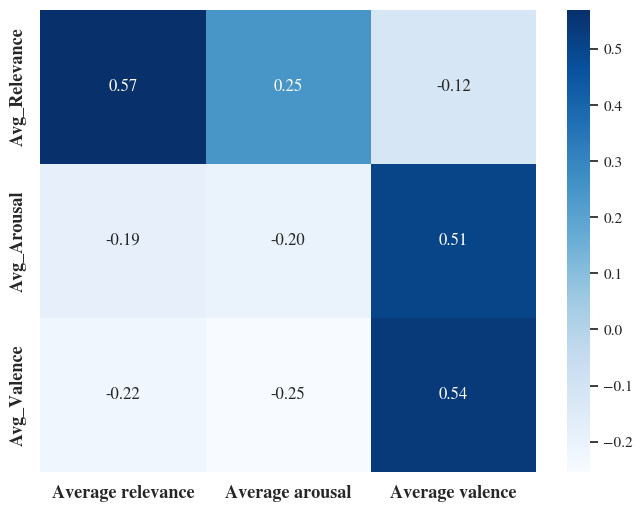

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_1.xlsx.png
Avg_Relevance - MAE: 1.280909090909091, MSE: 2.4971351097178682
Avg_Arousal - MAE: 0.8852351097178683, MSE: 1.2691739811912228
Avg_Valence - MAE: 0.7900313479623825, MSE: 0.9915567398119123
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


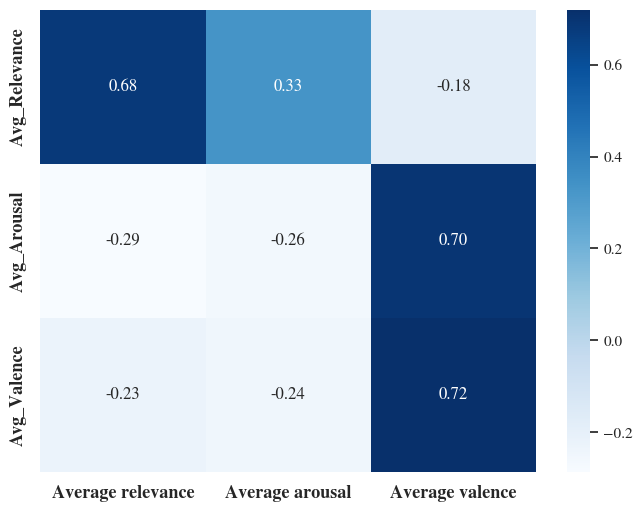

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_10.xlsx.png
Avg_Relevance - MAE: 1.4378996865203761, MSE: 3.096288714733542
Avg_Arousal - MAE: 0.9827272727272728, MSE: 1.5298134796238243
Avg_Valence - MAE: 0.9769905956112853, MSE: 1.5906601880877744
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


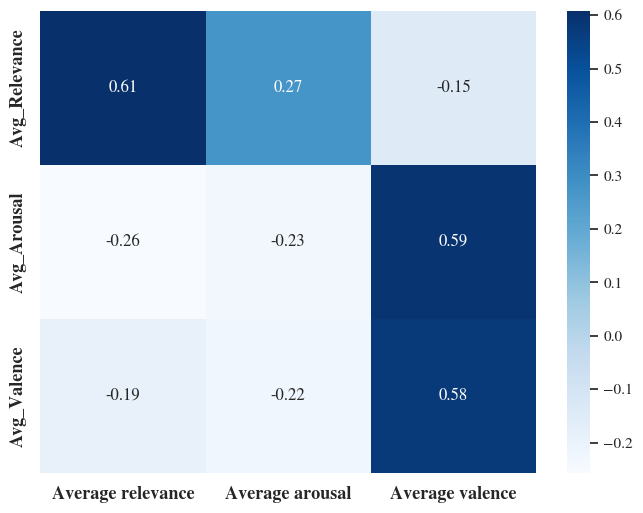

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_2.xlsx.png
Avg_Relevance - MAE: 1.3833751306165099, MSE: 2.8863235458028558
Avg_Arousal - MAE: 0.9419958202716824, MSE: 1.4334533263671196
Avg_Valence - MAE: 0.8953605015673981, MSE: 1.3075846046673634
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


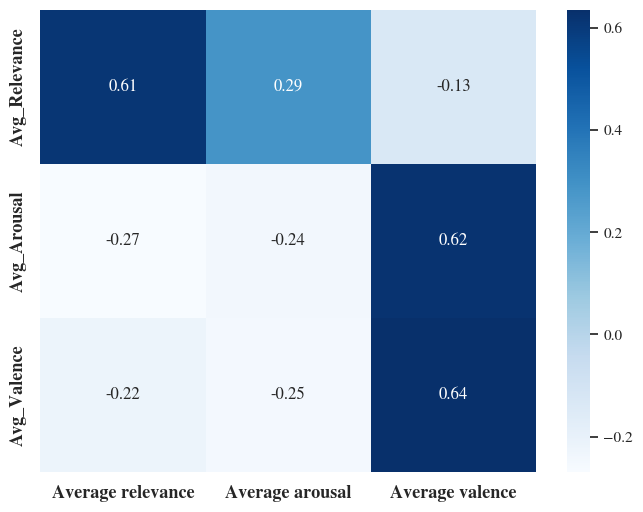

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_3.xlsx.png
Avg_Relevance - MAE: 1.3241379310344827, MSE: 2.7004971786833853
Avg_Arousal - MAE: 0.9425078369905955, MSE: 1.4023761755485893
Avg_Valence - MAE: 0.8588087774294672, MSE: 1.1913968652037619
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


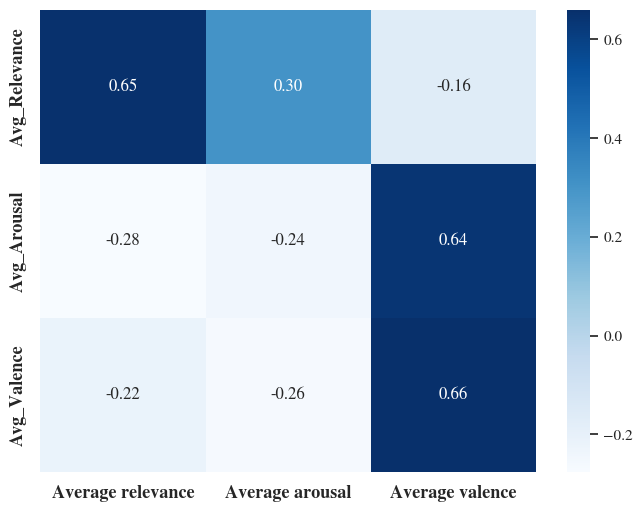

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_4.xlsx.png
Avg_Relevance - MAE: 1.3034796238244515, MSE: 2.6501006269592473
Avg_Arousal - MAE: 0.928432601880878, MSE: 1.3576943573667708
Avg_Valence - MAE: 0.835423197492163, MSE: 1.100910971786834
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


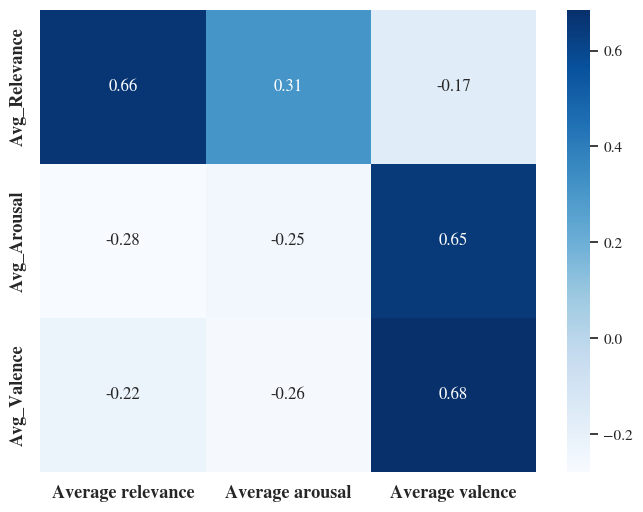

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_5.xlsx.png
Avg_Relevance - MAE: 1.2973354231974923, MSE: 2.596758934169279
Avg_Arousal - MAE: 0.9215778474399164, MSE: 1.3431468129571578
Avg_Valence - MAE: 0.8165099268547545, MSE: 1.054414977359805
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


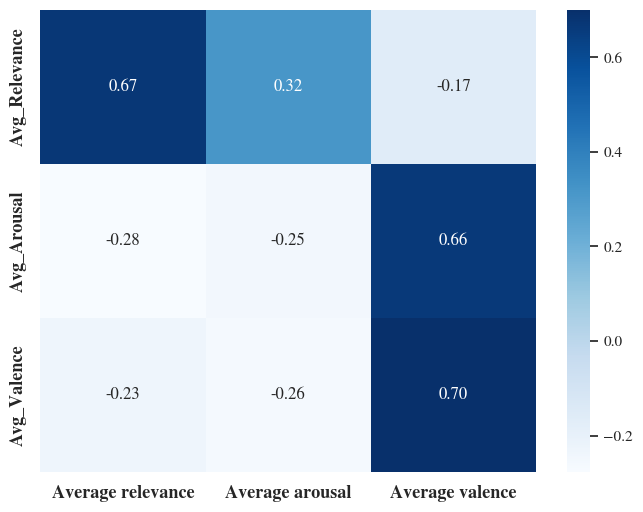

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_6.xlsx.png
Avg_Relevance - MAE: 1.2836587550380654, MSE: 2.5395661761883437
Avg_Arousal - MAE: 0.8892207792207792, MSE: 1.2856736293263387
Avg_Valence - MAE: 0.80692342140618, MSE: 1.0279840957072486
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


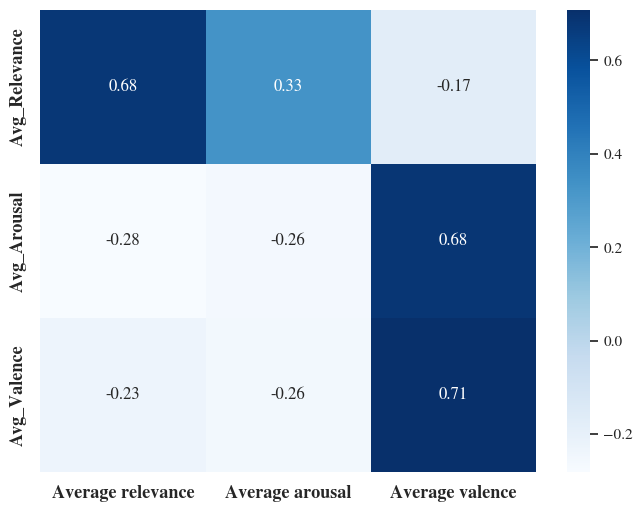

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_7.xlsx.png
Avg_Relevance - MAE: 1.2867084639498432, MSE: 2.5132871473354235
Avg_Arousal - MAE: 0.8939341692789969, MSE: 1.2865043103448277
Avg_Valence - MAE: 0.800705329153605, MSE: 0.9977036833855799
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


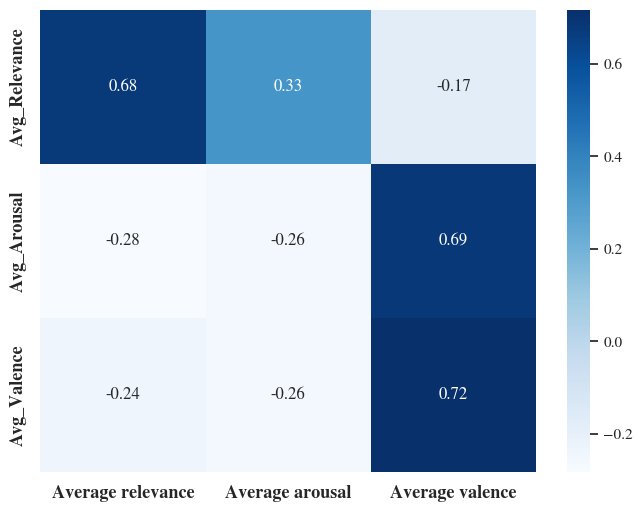

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_8.xlsx.png
Avg_Relevance - MAE: 1.282058516196447, MSE: 2.5103322148689964
Avg_Arousal - MAE: 0.8855764541971438, MSE: 1.267681431169937
Avg_Valence - MAE: 0.785377917102055, MSE: 0.9803033631332484
MAE and MSE results saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\all_mae_mse_results.txt


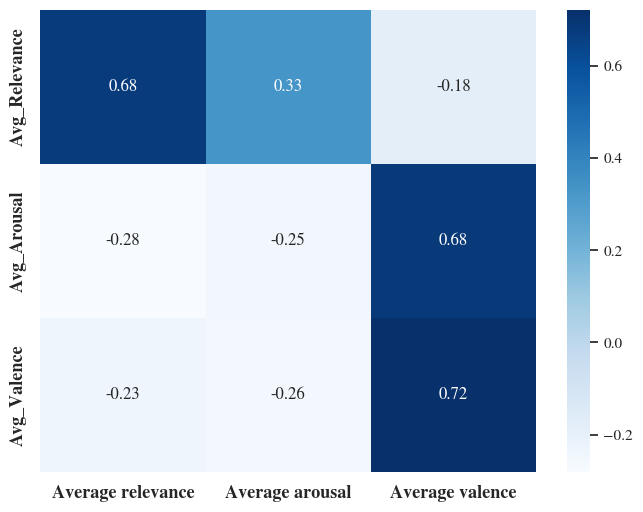

Correlation matrix saved to: C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results\correlation_matrix_Output_LLaVa_Mean_Ratings_all_320_group_9.xlsx.png


In [3]:
input_dir = r'C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\with_temperature\parsed_output_all_320_temperature_0.3\Mean_Folder' 
comparison_file = r'C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Data\Raw\aci_database_image_ratings.xlsx'  
output_dir = r'C:\Users\86158\Desktop\Research\LlaVa_Image_Encoder_Eval\Eval\Additional Results' 

calculate_mae_mse_for_files_and_plot_heatmaps(input_dir, comparison_file, output_dir)
